# Cats and Dogs Image Classification Using Machine Learning with Python

### The Ultimate Guide for building Binary Image Classifier by applying Image Analysis and Pre-processing techniques on unseen photos of Dogs and Cats.

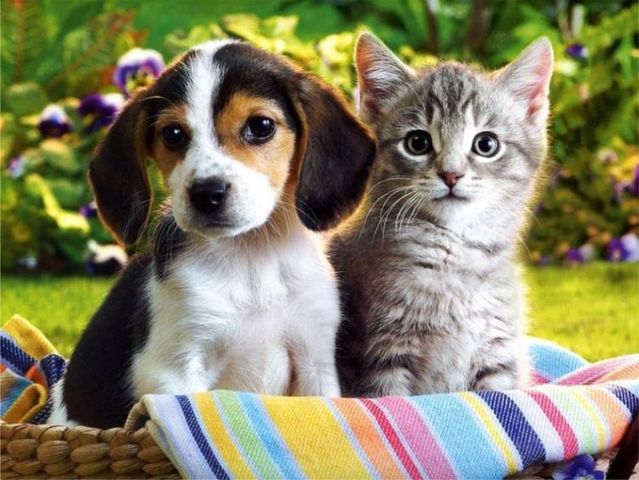

## Introduction

There’s a strong belief that when it comes to working with unstructured data, especially image data, deep learning models are the best. Deep learning algorithms undoubtedly perform extremely well, but is that the only way to work with images?

Have you ever wondered what if there was a way, we could classify the images of cats and dogs using Machine Learning? That would be great right? 

If we provide the right data and features, Machine learning models can perform adequately well and can even be used as an automated solution.

In this project, I will demonstrate and show how we can harness the power of Machine Learning and perform image classification using four popular machine learning algorithms like Random Forest Classifier, K-Nearest Neighbour (KNN) Classifier, Decision Tree Classifier, and Support Vector Machine (SVM).


## Problem Statement

The main objective of this task is to apply Machine learning algorithms to build Binary Image Classifier by applying Image Analysis and Pre-processing techniques on unseen photos of Dogs and Cats.


## Importing Libraries

In [ ]:
import os
import pandas as pd
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifie
from sklearn import svm

## Unzipping the dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip data
with zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r') as zip_ref: 
    zip_ref.extractall("/content/")

## Creating Separate Train and Test dataframe

In [ ]:
# load training data
df_train = pd.read_csv("/content/data/train.csv")

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,Id,Label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [ ]:
# load testing data
df_test = pd.read_csv("/content/data/test.csv")

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


,Id
0,1
1,2
2,3
3,4
4,5


## Checking Distribution of Label (Target Variable) in Train Data

In [ ]:
df_train['Label'].value_counts(normalize = True)

dog    0.5011
cat    0.4989
Name: Label, dtype: float64

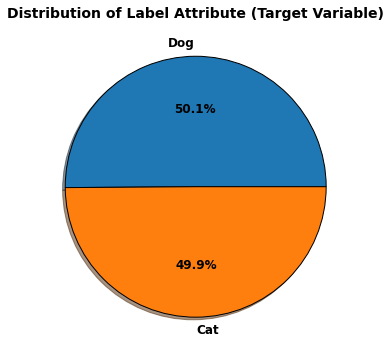

In [ ]:
plt.figure(figsize=(12,6))
proportion = df_train['Label'].value_counts()
labels = ['Dog','Cat']
plt.title('Distribution of Label Attribute (Target Variable)',fontsize = 14, weight = 'bold')
plt.pie(proportion,labels=labels,shadow = True, autopct = '%1.1f%%',wedgeprops= {'edgecolor':'black'},textprops= { 'fontsize': 12,'weight' : 'bold'});

## Checking Shape of Train and Test Data

In [ ]:
df_train.shape, df_test.shape

((10000, 2), (1000, 1))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      10000 non-null  int64 
 1   Label   10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


## Feature Encoding - Custom Mapping "Label"

To apply Machine Learning algorithms, we need to encode the features from categorical to numerical data types. Hence, I will apply one of the Feature Encoding methods on the “Label” target column by applying Custom Mapping labelling Cat as 0 and Dog as 1.

In [ ]:
df_train['Label'] = df_train['Label'].map({'cat': 0, 'dog' : 1})
df_train.head()

,Id,Label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   Label   10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


## Creating Separate Train and Test folders to Load Images 

In [ ]:
# method to load images
# parameters
# ids - list of image ids
# folder_path - path to image folder
# dim - dimensions to resize images

def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, "{}.jpg".format(id))
    img = cv2.imread(image_path)

    # Resize if necessary
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
      img = cv2.resize(img, dim)
    images.append(img)
  return images

In [ ]:
base_dim = (200, 200)

# load train images
train_image_folder = "/content/data/train_images"
train_images = load_images(df_train['Id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = "/content/data/test_images"
test_images = load_images(df_test['Id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

Number of training images loaded: 10000
Number of testing images loaded: 1000


## Model Building

In [ ]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['0', '1']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=[0, 1])
  return accuracy, confusion_matrix

## Feature Extraction and Model Building


### Image Pre-processing on Train Data

####1.	Image Manipulation

- Gray Scaling: Grayscale is a range of monochromatic shades from black to white. Gray scaling in converting images to grayscale. 

- Resizing: Image resizing refers to either enlarging or shrinking images. Machine learning algorithms require the same size images during the learning and prediction phases. To convert all images to a common size, we need to define a base image size and resize images. 

- Smoothing/Blurring: Smoothing is commonly used for noise reduction in images. It reduces irrelevant details such as pixel regions that are small for the filter kernel size. In this task, I have applied the Gaussian Filtering technique which assigns the Gaussian weighted average of all the pixels under the kernel area as the central element value.

#### 2.	Feature Extraction

- Image Vectorisation: Method to convert an image to a vector is matrix vectorisation. Colour image vectorisation results in very long vectors which leads to a curse of dimensionality. Hence, the simplest solution is image gray scaling when compared to vectorisation.

- Edge Detection: Edge detection is an image processing technique that finds the boundaries of objects within images. In this task, I have applied Canny edge detection is an optimal algorithm for edge detection which helps in Noise reduction, finding intensity gradient of the image, filters out non-real edges and removing pixels that may not constitute edges

- HOG Feature Descriptor:  Histogram of Oriented Gradients feature descriptor counts the occurrences of gradient orientation in localised portions of an image as to features. It mainly focuses on the shape or the structure of objects. 

- Principle Component Analysis (PCA): PCA is a dimensionality reduction technique that uses Singular Value Decomposition of the data to project it to a lower-dimensional space.




### Implementation of Machine Learning Algorithms

1.	Support Vector Machine (SVM) Classifier	(M1 - M6)
2.	Decision Tree Classifier				(M7 - M12)
3.	K-Nearest Neighbour (KNN) Classifier		(M13 - M18)
4.	Random Forest Classifier 				(M19 - M24)


### Model (1-6) : Support Vector Machine (SVM)

#### M1

- Preprocessing - Gray scaling
- Features - Image vector
- Algorithm - SVM

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  svm_clf = svm.SVC(kernel='linear', random_state=100) 
  svm_clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = svm_clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return svm_clf

In [ ]:
# method to get image features
def get_features_m1(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.516


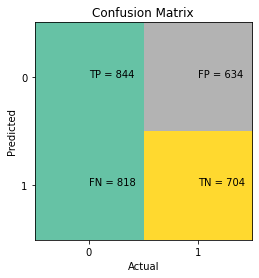

In [ ]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### M2

- Preprocessing - Gray scaling + Smoothing
- Features - Image vector
- Algorithm - SVM

To smooth images, I will use Gaussian filtering.

Image Id: 2386
Image Id: 7528
Image Id: 7453
Image Id: 2863
Image Id: 6439
Image Id: 5730
Image Id: 7102
Image Id: 8304
Image Id: 1801
Image Id: 8731


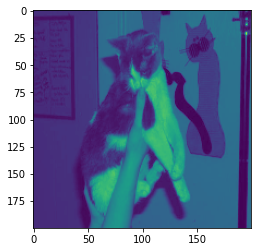

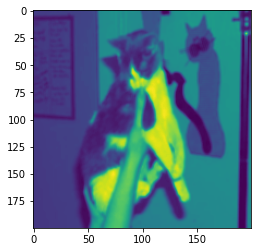

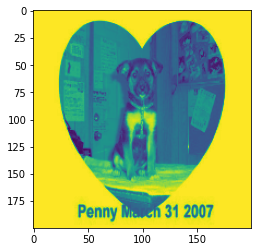

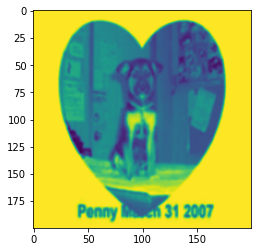

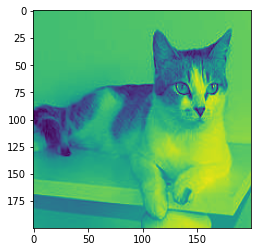

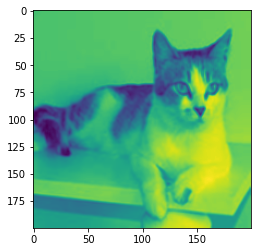

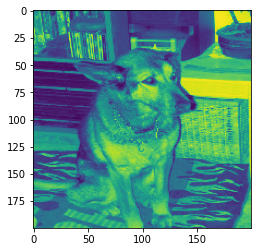

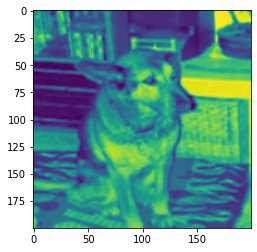

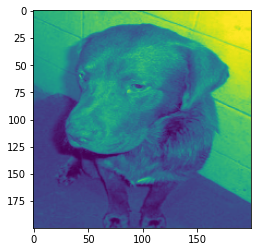

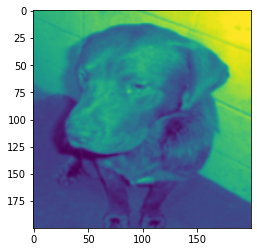

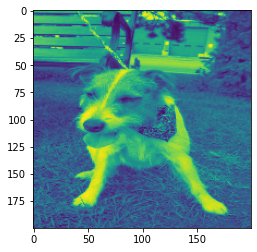

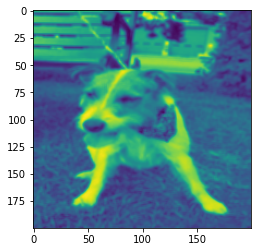

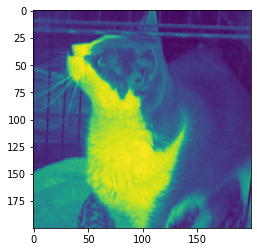

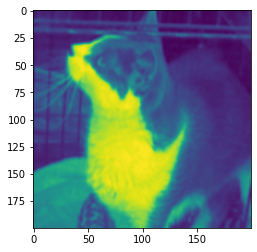

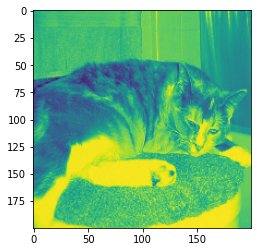

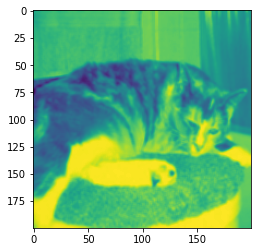

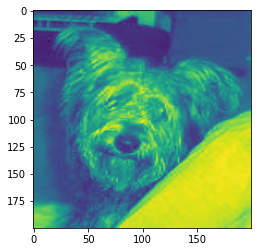

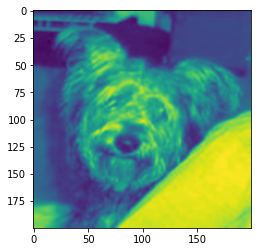

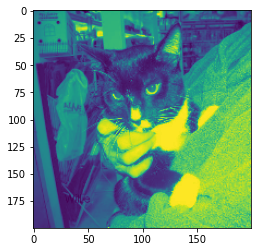

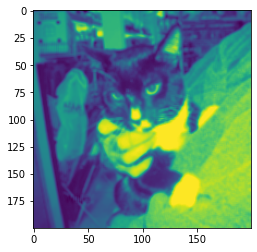

In [ ]:
from random import randint
from random import seed

seed(100)
sample_images = []

# pick random sample of images
for i in range(10):
  value = randint(0, len(train_images)-1)
  print(f'Image Id: {value}')
  sample_images.append(train_images[value])

# apply preprocessing and show output images
for img in sample_images:
  img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.imshow(img_grayscaled)
  plt.show()

  img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)
  plt.imshow(img_blurred)
  plt.show()

In [ ]:
# method to get image features
def get_features_m2(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5146666666666667


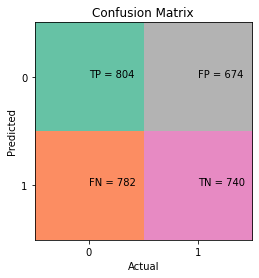

In [ ]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model2 = get_svm_predictions(X_train, X_val, y_train, y_val)

#### M3

- Preprocessing - Gray scaling
- Features - Edge map to vector
- Algorithm - SVM

For edge detection, I will  Canny edge detection algorithm.

In [ ]:
# method to get image features
def get_features_m3(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5753333333333334


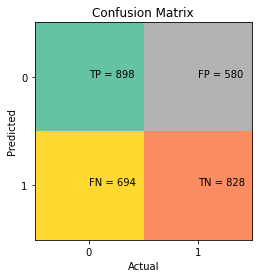

In [ ]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model3 = get_svm_predictions(X_train, X_val, y_train, y_val)

#### M4
- Preprocessing - Gray scaling
- Features - HOG features
- Algorithm - SVM

In [ ]:
# method to get image features
def get_features_m4(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 3780)
Accuracy: 0.6696666666666666


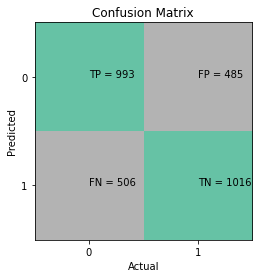

In [ ]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model4 = get_svm_predictions(X_train, X_val, y_train, y_val)

#### M5

- Preprocessing - Gray scaling
- Features - Image vector + Edge map vector
- Algorithm - SVM

In [ ]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 80000)
Accuracy: 0.5786666666666667


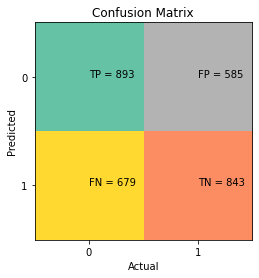

In [ ]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model5 = get_svm_predictions(X_train, X_val, y_train, y_val)

#### M6

- Preprocessing - Gray scaling
- Features - 5000 principle components of Image vector
- Algorithm - SVM

In [ ]:
# method to get image features
def get_features_m6(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  
  return features_list

(10000, 40000)
(10000, 5000)
Accuracy: 0.5063333333333333


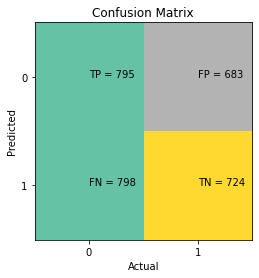

In [ ]:
# feature extraction
features_train = get_features_m6(train_images)
print(features_train.shape)

# Principal component extraction
pca = PCA(n_components=5000)
pca.fit(features_train)
features_train_updated = pca.transform(features_train)
print(features_train_updated.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_updated, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
svm_model6 = get_svm_predictions(X_train, X_val, y_train, y_val)

### Model (7-12) : Decision Tree Classifier

#### M7
- Preprocessing - Gray scaling
- Features - Image vector
- Algorithm - Decision Tree Classifier

In [ ]:
# method to train and predict using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

def get_dt_predictions(X_train, X_val, y_train, y_val):
  # build model
  dt_clf = DecisionTreeClassifier(random_state=100) 
  dt_clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = dt_clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return dt_clf

In [ ]:
# method to get image features
def get_features_m7(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5616666666666666


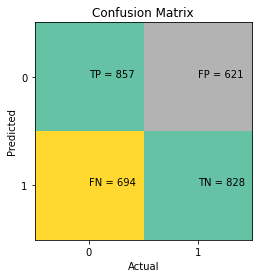

In [ ]:
# feature extraction
features_train = get_features_m7(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model1 = get_dt_predictions(X_train, X_val, y_train, y_val)

#### M8

- Preprocessing - Gray scaling + Smoothing
- Features - Image vector
- Algorithm - Decision Tree Classifier

To smooth images, I will use Gaussian filtering.

In [ ]:
# method to get image features
def get_features_m8(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5533333333333333


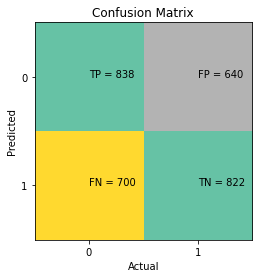

In [ ]:
# feature extraction
features_train = get_features_m8(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model2 = get_dt_predictions(X_train, X_val, y_train, y_val)

#### M9

- Preprocessing - Gray scaling
- Features - Edge map to vector
- Algorithm - Decision Tree Classifier

For edge detection, I will use Canny edge detection algorithm.

In [ ]:
# method to get image features
def get_features_m9(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.533


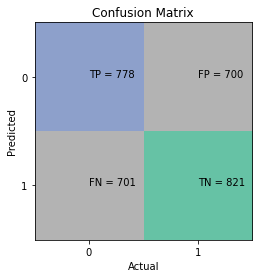

In [ ]:
# feature extraction
features_train = get_features_m9(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model3 = get_dt_predictions(X_train, X_val, y_train, y_val)

#### M10
- Preprocessing - Gray scaling
- Features - HOG features
- Algorithm - Decision Tree Classifier

In [ ]:
# method to get image features
def get_features_m10(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 3780)
Accuracy: 0.592


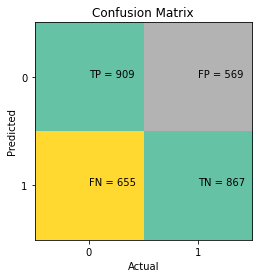

In [ ]:
# feature extraction
features_train = get_features_m10(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model4 = get_dt_predictions(X_train, X_val, y_train, y_val)

#### M11

- Preprocessing - Gray scaling
- Features - Image vector + Edge map vector
- Algorithm - Decision Tree Classifier

In [ ]:
# method to get image features
def get_features_m11(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 80000)
Accuracy: 0.5496666666666666


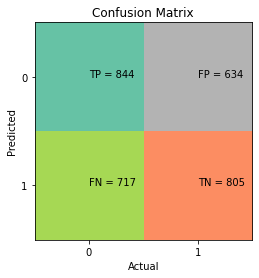

In [ ]:
# feature extraction
features_train = get_features_m11(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model5 = get_dt_predictions(X_train, X_val, y_train, y_val)

#### M12

- Preprocessing - Gray scaling
- Features - 5000 principle components of Image vector
- Algorithm - Decision Tree Classifier

In [ ]:
# method to get image features
def get_features_m12(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  
  return features_list

(10000, 40000)
(10000, 5000)
Accuracy: 0.5303333333333333


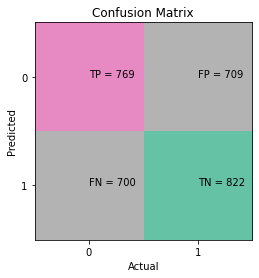

In [ ]:
# feature extraction
features_train = get_features_m12(train_images)
print(features_train.shape)

# Principal component extraction
pca = PCA(n_components=5000)
pca.fit(features_train)
features_train_updated = pca.transform(features_train)
print(features_train_updated.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_updated, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
dt_model6 = get_dt_predictions(X_train, X_val, y_train, y_val)

### Model (13-18): K- Nearest Neighbors (KNN) Classifier

#### M13
- Preprocessing - Gray scaling
- Features - Image vector
- Algorithm - KNN Classifier

In [ ]:
# method to train and predict using KNN classifier
from sklearn.neighbors import KNeighborsClassifier

def get_knn_predictions(X_train, X_val, y_train, y_val):
  # build model
  knn_clf = KNeighborsClassifier(n_neighbors=5) 
  knn_clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = knn_clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return knn_clf

In [ ]:
# method to get image features
def get_features_m13(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.552


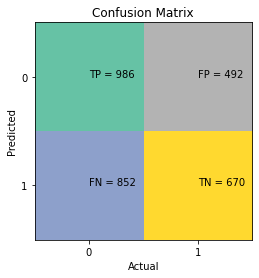

In [ ]:
# feature extraction
features_train = get_features_m13(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model1 = get_knn_predictions(X_train, X_val, y_train, y_val)

#### M14

- Preprocessing - Gray scaling + Smoothing
- Features - Image vector
- Algorithm - KNN Classifier

To smooth images, I will use Gaussian filtering.

In [ ]:
# method to get image features
def get_features_m14(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5583333333333333


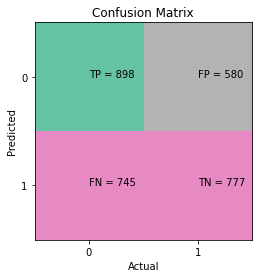

In [ ]:
# feature extraction
features_train = get_features_m14(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model2 = get_knn_predictions(X_train, X_val, y_train, y_val)

#### M15

- Preprocessing - Gray scaling
- Features - Edge map to vector
- Algorithm - KNN Classifier

For edge detection, I will use Canny edge detection algorithm

In [ ]:
# method to get image features
def get_features_m15(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.49266666666666664


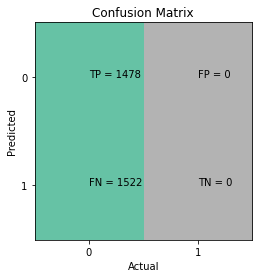

In [ ]:
# feature extraction
features_train = get_features_m15(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model3 = get_knn_predictions(X_train, X_val, y_train, y_val)

#### M16
- Preprocessing - Gray scaling
- Features - HOG features
- Algorithm - KNN Classifier

In [ ]:
# method to get image features
def get_features_m16(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 3780)
Accuracy: 0.5913333333333334


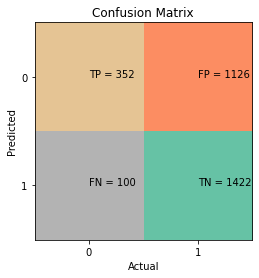

In [ ]:
# feature extraction
features_train = get_features_m16(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model4 = get_knn_predictions(X_train, X_val, y_train, y_val)

#### M17

- Preprocessing - Gray scaling
- Features - Image vector + edge map vector
- Algorithm - KNN Classifier 

In [ ]:
# method to get image features
def get_features_m17(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 80000)
Accuracy: 0.5143333333333333


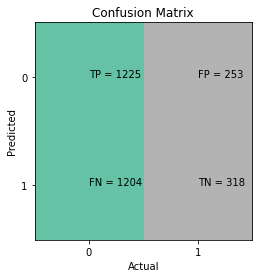

In [ ]:
# feature extraction
features_train = get_features_m17(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model5 = get_knn_predictions(X_train, X_val, y_train, y_val)

#### M18

- Preprocessing - Gray scaling
- Features - 5000 principle components of Image vector
- Algorithm - KNN Classifier

In [ ]:
# method to get image features
def get_features_m18(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  
  return features_list

(10000, 40000)
(10000, 5000)
Accuracy: 0.5486666666666666


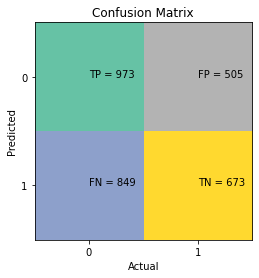

In [ ]:
# feature extraction
features_train = get_features_m18(train_images)
print(features_train.shape)

# Principal component extraction
pca = PCA(n_components=5000)
pca.fit(features_train)
features_train_updated = pca.transform(features_train)
print(features_train_updated.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_updated, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
knn_model6 = get_knn_predictions(X_train, X_val, y_train, y_val)

### Model (19-24): Random Forest Classifier

#### M19
- Preprocessing - Gray scaling
- Features - Image vector
- Algorithm - Random Forest Classifier

In [ ]:
# method to train and predict using Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

def get_rf_predictions(X_train, X_val, y_train, y_val):
  # build model
  rf_clf = RandomForestClassifier(random_state= 100) 
  rf_clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = rf_clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return rf_clf

In [ ]:
# method to get image features
def get_features_m19(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.6073333333333333


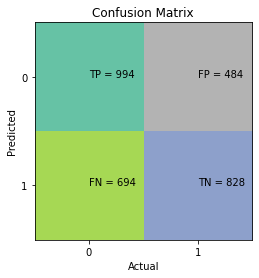

In [ ]:
# feature extraction
features_train = get_features_m19(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model1 = get_rf_predictions(X_train, X_val, y_train, y_val)

#### M20

- Preprocessing - Gray scaling + smoothing
- Features - Image vector
- Algorithm - Random Forest Classifier

To smooth images, I will use Gaussian filtering.

In [ ]:
# method to get image features
def get_features_m20(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.62


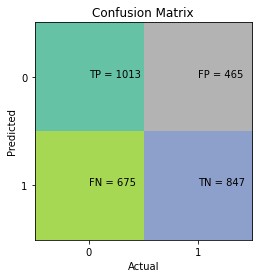

In [ ]:
# feature extraction
features_train = get_features_m20(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model2 = get_rf_predictions(X_train, X_val, y_train, y_val)

#### M21

- Preprocessing - Gray scaling
- Features - Edge map to vector
- Algorithm - Random Forest Classifier

For edge detection, I will use Canny edge detection algorithm

In [ ]:
# method to get image features
def get_features_m21(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.5866666666666667


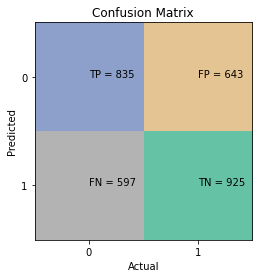

In [ ]:
# feature extraction
features_train = get_features_m21(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model3 = get_rf_predictions(X_train, X_val, y_train, y_val)

#### M22
- Preprocessing - Gray scaling
- Features - HOG features
- Algorithm - Random Forest Classifier

In [ ]:
# method to get image features
def get_features_m22(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 3780)
Accuracy: 0.7


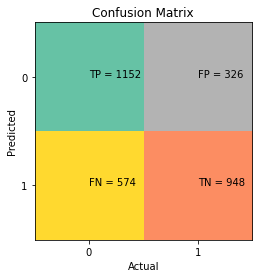

In [ ]:
# feature extraction
features_train = get_features_m22(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model4 = get_rf_predictions(X_train, X_val, y_train, y_val)

#### M23

- Preprocessing - Gray scaling
- Features - Image vector + edge map vector
- Algorithm - Random Forest Classifier

In [ ]:
# method to get image features
def get_features_m23(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 80000)
Accuracy: 0.6326666666666667


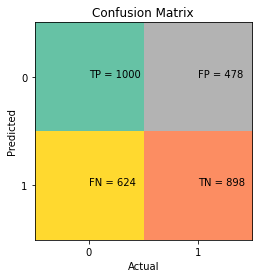

In [ ]:
# feature extraction
features_train = get_features_m23(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model5 = get_rf_predictions(X_train, X_val, y_train, y_val)

#### M24

- Preprocessing - Gray scaling
- Features - 5000 principle components of Image vector
- Algorithm - Random Forest Classifier

In [ ]:
# method to get image features
def get_features_m24(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  
  return features_list

(10000, 40000)
(10000, 5000)
Accuracy: 0.592


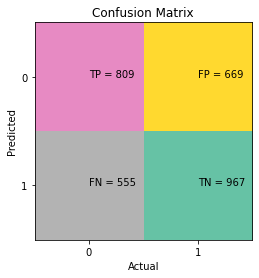

In [ ]:
# feature extraction
features_train = get_features_m24(train_images)
print(features_train.shape)

# Principal component extraction
pca = PCA(n_components=5000)
pca.fit(features_train)
features_train_updated = pca.transform(features_train)
print(features_train_updated.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_updated, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
rf_model6 = get_rf_predictions(X_train, X_val, y_train, y_val)

### Summary of Machine Learning Model Accuracy on Train and Validation Data

From all the Machine Learning Models, Random Forest Classifier (M22) with Gray scaling and HOG Feature has achieved the best Accuracy of 70% followed by Support Vector Machine (SVM) Classifier with Gray scaling and HOG Feature with 67% Accuracy.


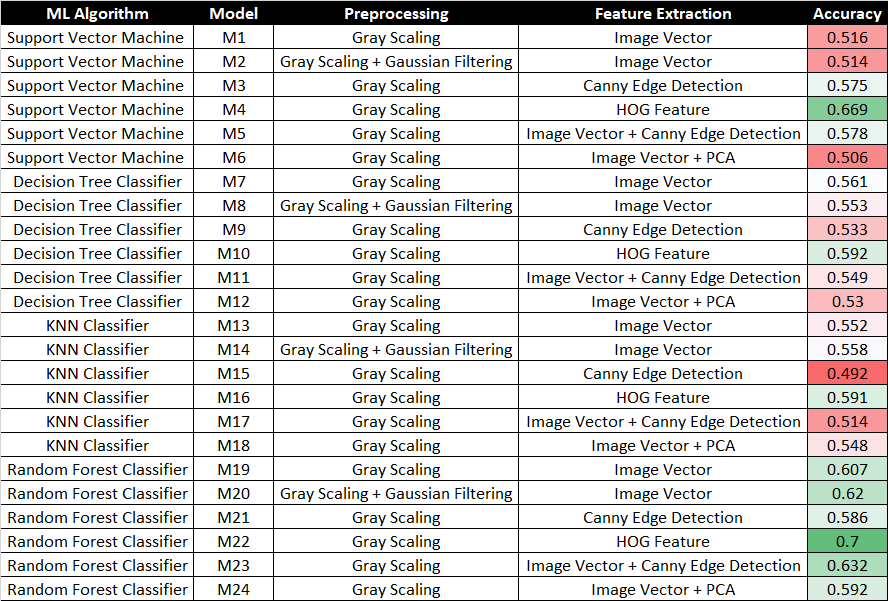

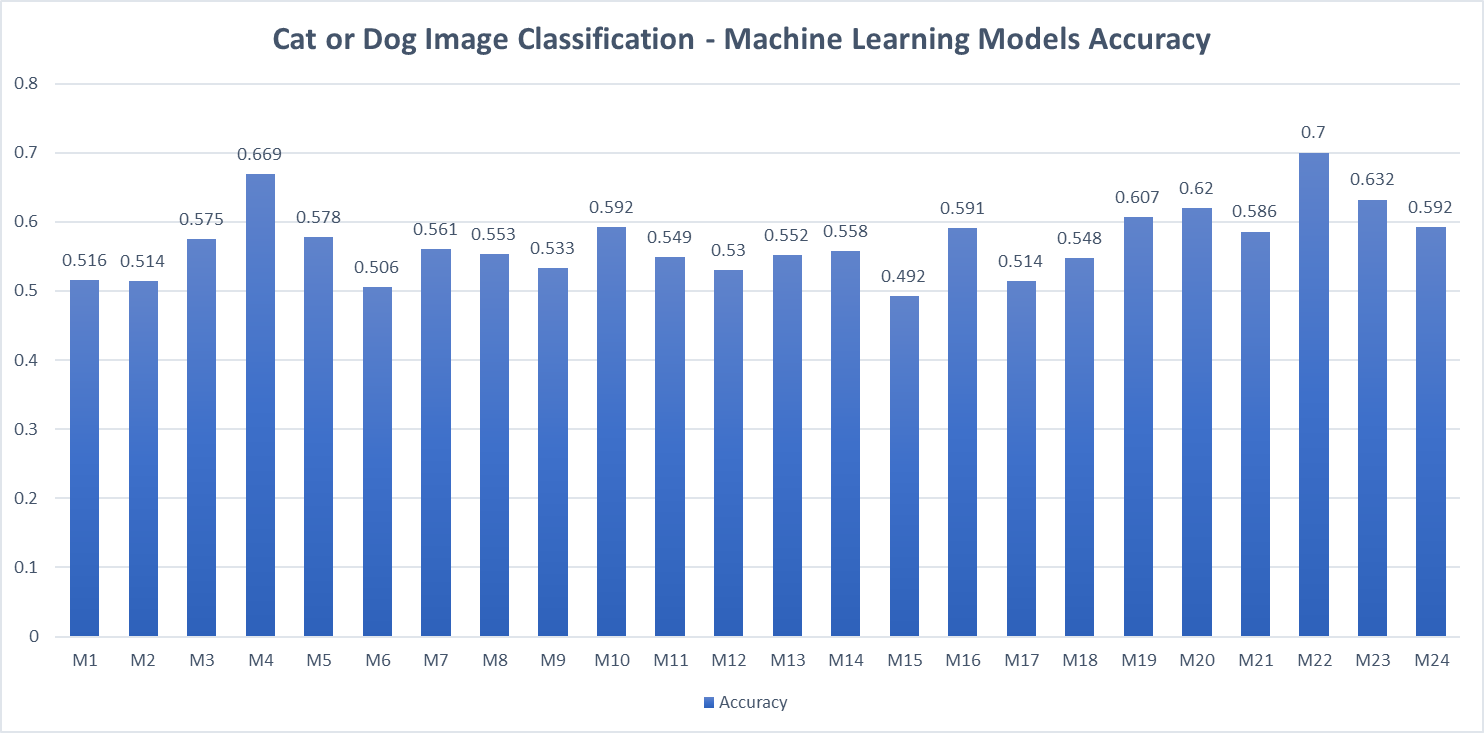

## Predictions on Test Data

Using the best ML Model Random Forest Classifier (M22), we will make predictions on test data and save predictions on .csv file name “test-predictions.csv”

In [ ]:
# feature extraction - test data
features_test = get_features_m22(test_images)
print(features_test.shape)

(1000, 3780)


In [ ]:
#make predictions using the best model
predictions = rf_model4.predict(features_test)
print(predictions)

[1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1
 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1
 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0
 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1
 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0
 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 1 1 0 0 

In [ ]:
# add predictions to the ‘Label’ column in test data
df_test['Label'] = predictions

In [ ]:
df_test.to_csv('/content/test-predictions_1.csv', index = False)

In [ ]:
df1_test = pd.read_csv('/content/test-predictions_1.csv')
df1_test.head()

,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1


In [ ]:
#Custom Mapping Label Class - Cat as 0 and Dog as 1
df1_test['Label'] = df1_test['Label'].map({ 0: 'cat', 1: 'dog'})
df1_test.head(10)

,Id,Label
0,1,dog
1,2,cat
2,3,cat
3,4,cat
4,5,dog
5,6,dog
6,7,dog
7,8,dog
8,9,cat
9,10,dog


### Distribution of Predictions - Label Class on Test Data

In [ ]:
df1_test['Label'].value_counts(normalize = True)

cat    0.57
dog    0.43
Name: Label, dtype: float64

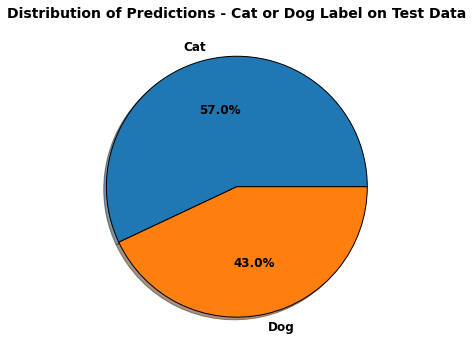

In [ ]:
plt.figure(figsize=(12,6))
proportion = df1_test['Label'].value_counts()
labels = ['Cat','Dog']
plt.title('Distribution of Predictions - Cat or Dog Label on Test Data',fontsize = 14, weight = 'bold')
plt.pie(proportion,labels=labels,shadow = True, autopct = '%1.1f%%',wedgeprops= {'edgecolor':'black'},textprops= { 'fontsize': 12,'weight' : 'bold'});

In [ ]:
# save data frame to .csv file 
df1_test.to_csv('/content/test-predictions.csv', index = False)

## Conclusion 

In this blog, we discussed how to approach binary Image classification problem by implementing four ML algorithms including Random Forest, KNN, Decision Tree, and Support Vector Machines. 

Out of these 4 ML Algorithms, Random Forest Classifier with HOG Feature extraction shows the best performance with 70% accuracy.

We can explore this work further by trying to improve the Machine Learning Image classification using hyperparameter tuning and Deep learning algorithms.
